# Compare spread and eigenvalue centrality when choosing vertices to remove

On several test graphs, use both centrality measures to select vertices to remove, one by one, until a fixed number of vertices is reached (where the number is selected based on the size of the graph). 

In [1]:
import igraph
from scipy.io import mmread
from scipy.linalg import eigh
import numpy as np
from dissim.igraph_util import nodes_from_igraph, colors_from_nodes
from dissim.main import DSState
from dissim.death_ftn import generate_normal_death_ftn_factory
from dissim.rng import SimpleSampler
from dissim.centrality import compute_spread_centrality_of_matrix, compute_eigenvector_centrality_of_matrix
import matplotlib.pyplot as plt

In [2]:
def largest_eigenvalue(adj: np.array) -> float:
    n = adj.shape[0]
    w = eigh(adj, eigvals_only=True, subset_by_index=[n - 1, n - 1])
    return np.real(w)[0]

In [3]:
def remove_vertex(adj, i):
    result = np.delete(adj, i, axis=0)
    result = np.delete(result, i, axis=1)
    return result

## 1. Karate graph

In [4]:
matrix = mmread("/home/rkingan/winhome/Documents/dev/src/sandra-math5001-2022/soc-karate.mtx")
adj = matrix.todense()
n = adj.shape[0]
to_remove = 8 # around 1/4 of the graph
print(n)

34


### Spread centrality

In [5]:
sampler = SimpleSampler(42)
minor = adj
nn = n
original_labels = list(range(n))
ss_removed = []
ss_largest_eigenvalues = [largest_eigenvalue(minor)]
for i in range(to_remove):
    cent = compute_spread_centrality_of_matrix(minor)
    max_cent = max(cent)
    which_max = [i for i in range(nn) if cent[i] == max_cent]
    if len(which_max) > 1:
        j = sampler(which_max, 1)[0]
    else:
        j = which_max[0]
    minor = remove_vertex(minor, j)
    ss_removed.append(original_labels[j])
    del original_labels[j]
    nn -= 1
    ss_largest_eigenvalues.append(largest_eigenvalue(minor))
    

In [6]:
print(f"Largest eigenvalue: {ss_largest_eigenvalues[0]:10.4f}")
print(" i  vertex  largest eigenvalue")
for i in range(to_remove):
    print(f"{i + 1:2d}   {ss_removed[i]:2d}   {ss_largest_eigenvalues[i + 1]:10.4f}")

Largest eigenvalue:     6.7257
 i  vertex  largest eigenvalue
 1   33       6.0880
 2    0       4.6220
 3    2       3.6942
 4   32       3.1525
 5    1       2.6189
 6   31       2.4812
 7    4       2.1753
 8   27       2.1701


### Eigenvector centrality

In [7]:
sampler = SimpleSampler(42)
minor = adj
nn = n
original_labels = list(range(n))
eig_removed = []
eig_largest_eigenvalues = [largest_eigenvalue(minor)]
for i in range(to_remove):
    cent = compute_eigenvector_centrality_of_matrix(minor)
    max_cent = max(cent)
    which_max = [i for i in range(nn) if cent[i] == max_cent]
    if len(which_max) > 1:
        j = sampler(which_max, 1)[0]
    else:
        j = which_max[0]
    minor = remove_vertex(minor, j)
    eig_removed.append(original_labels[j])
    del original_labels[j]
    nn -= 1
    eig_largest_eigenvalues.append(largest_eigenvalue(minor))
    

In [8]:
print(f"Largest eigenvalue: {eig_largest_eigenvalues[0]:10.4f}")
print(" i  vertex  largest eigenvalue")
for i in range(to_remove):
    print(f"{i + 1:2d}   {eig_removed[i]:2d}   {eig_largest_eigenvalues[i + 1]:10.4f}")

Largest eigenvalue:     6.7257
 i  vertex  largest eigenvalue
 1   33       6.0880
 2    0       4.6220
 3    2       3.6942
 4   32       3.1525
 5    1       2.6189
 6   25       2.4812
 7   14       2.4812
 8   11       2.4812


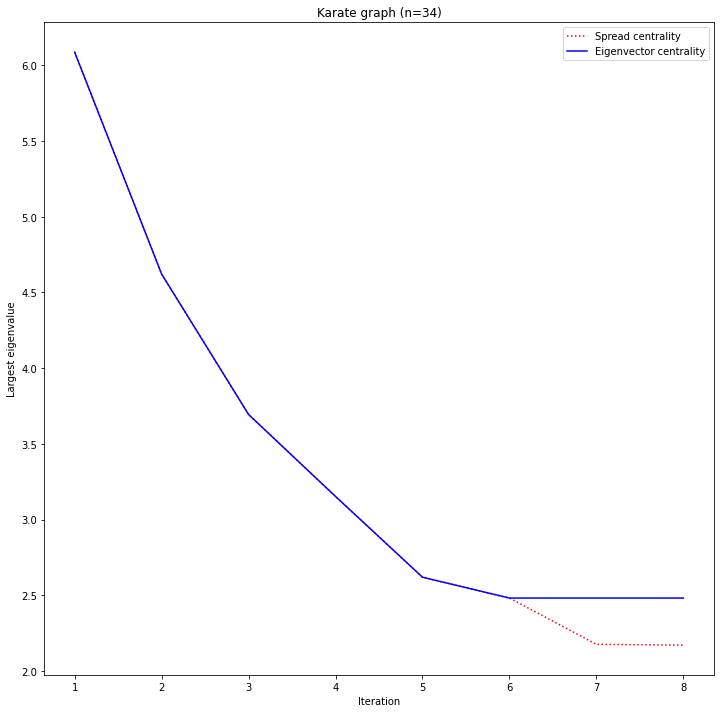

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))
X = list(range(1, 1 + to_remove))
Y1 = ss_largest_eigenvalues[1:]
Y2 = eig_largest_eigenvalues[1:]
ax.plot(X, Y1, color="red", label="Spread centrality", linestyle="dotted")
ax.plot(X, Y2, color="blue", label="Eigenvector centrality", linestyle="-")
ax.set_ylabel("Largest eigenvalue")
ax.set_xlabel("Iteration")
ax.set_title("Karate graph (n=34)")
ax.legend()
plt.show()

## 2. Football graph

In [10]:
G = igraph.Graph.Read_GML("/home/rkingan/winhome/Documents/dev/src/sandra-math5001-2022/Graphs-Large-02/football.gml").as_undirected()

In [11]:
adj = np.array(G.get_adjacency().data)
n = adj.shape[0]
to_remove = int(n / 4)
print(n, to_remove)

115 28


### Spread centrality

In [12]:
sampler = SimpleSampler(42)
minor = adj
nn = n
original_labels = list(range(n))
ss_removed = []
ss_largest_eigenvalues = [largest_eigenvalue(minor)]
ss_num_ties = []
for i in range(to_remove):
    cent = compute_spread_centrality_of_matrix(minor)
    max_cent = max(cent)
    which_max = [i for i in range(nn) if cent[i] == max_cent]
    ss_num_ties.append(len(which_max))
    if len(which_max) > 1:
        j = sampler(which_max, 1)[0]
    else:
        j = which_max[0]
    minor = remove_vertex(minor, j)
    ss_removed.append(original_labels[j])
    del original_labels[j]
    nn -= 1
    ss_largest_eigenvalues.append(largest_eigenvalue(minor))
    if (i + 1) % 10 == 0:
        print(f"i={i}, largest eigenvalue={ss_largest_eigenvalues[-1]:9.4f}")

i=9, largest eigenvalue=   9.5848
i=19, largest eigenvalue=   8.3700


In [13]:
print(f"Largest eigenvalue: {ss_largest_eigenvalues[0]:10.4f}")
print(" i  vertex  ties  largest eigenvalue")
for i in range(to_remove):
    print(f"{i + 1:2d}   {ss_removed[i]:3d}     {ss_num_ties[i]:2d}   {ss_largest_eigenvalues[i + 1]:10.4f}")

Largest eigenvalue:    10.7806
 i  vertex  ties  largest eigenvalue
 1    67      1      10.6425
 2     2      1      10.5128
 3     0      1      10.4002
 4     7      1      10.2931
 5    44      1      10.1746
 6    62      1      10.0637
 7    55      1       9.9560
 8     5      1       9.8242
 9    32      1       9.7019
10    25      1       9.5848
11    38      1       9.4800
12    88      1       9.3545
13    92      1       9.2450
14    51      1       9.1121
15    70      1       8.9858
16    72      1       8.8659
17    80      1       8.7231
18    17      1       8.6131
19    34      1       8.5003
20     9      1       8.3700
21    84      1       8.2458
22   109      1       8.1373
23    60      1       8.0108
24    48      1       7.8914
25    78      1       7.7625
26    82      1       7.6658
27    87      1       7.5507
28    43      1       7.4286


### Eigenvector centrality

In [14]:
sampler = SimpleSampler(42)
minor = adj
nn = n
original_labels = list(range(n))
eig_removed = []
eig_largest_eigenvalues = [largest_eigenvalue(minor)]
eig_num_ties = []
for i in range(to_remove):
    cent = compute_eigenvector_centrality_of_matrix(minor)
    max_cent = max(cent)
    which_max = [i for i in range(nn) if cent[i] == max_cent]
    eig_num_ties.append(len(which_max))
    if len(which_max) > 1:
        j = sampler(which_max, 1)[0]
    else:
        j = which_max[0]
    minor = remove_vertex(minor, j)
    eig_removed.append(original_labels[j])
    del original_labels[j]
    nn -= 1
    eig_largest_eigenvalues.append(largest_eigenvalue(minor))

In [15]:
print(f"Largest eigenvalue: {eig_largest_eigenvalues[0]:10.4f}")
print(" i  eig-v  eig-largest-eig  ss-v ss-largest-eig")
ss_wins = 0
for i in range(to_remove):
    if ss_largest_eigenvalues[i + 1] < eig_largest_eigenvalues[i + 1]:
        ss_wins += 1
        winner = "ss"
    else:
        winner = "eig"
    print(f"{i + 1:2d}   {eig_removed[i]:3d}   {eig_largest_eigenvalues[i + 1]:10.4f}       {ss_removed[i]:3d} {ss_largest_eigenvalues[i + 1]:10.4f}  {winner} ")
    
print(ss_wins, to_remove - ss_wins)

Largest eigenvalue:    10.7806
 i  eig-v  eig-largest-eig  ss-v ss-largest-eig
 1    67      10.6425        67    10.6425  eig 
 2     2      10.5128         2    10.5128  eig 
 3     7      10.4030         0    10.4002  ss 
 4     1      10.2692         7    10.2931  eig 
 5    35      10.1656        44    10.1746  eig 
 6     5      10.0509        62    10.0637  eig 
 7    87       9.9266        55     9.9560  eig 
 8    32       9.8050         5     9.8242  eig 
 9    91       9.6926        32     9.7019  eig 
10    61       9.5840        25     9.5848  eig 
11    23       9.4599        38     9.4800  eig 
12    88       9.3305        88     9.3545  eig 
13    70       9.2111        92     9.2450  eig 
14    51       9.1161        51     9.1121  ss 
15    38       8.9924        70     8.9858  ss 
16   109       8.8748        72     8.8659  ss 
17    81       8.7306        80     8.7231  ss 
18    48       8.6101        17     8.6131  eig 
19    55       8.4941        34     8.5003  

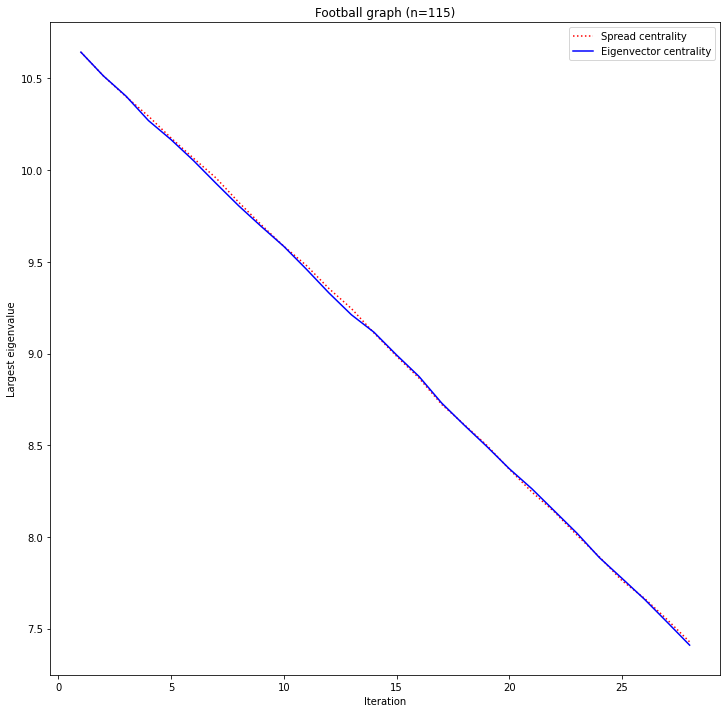

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))
X = list(range(1, 1 + to_remove))
Y1 = ss_largest_eigenvalues[1:]
Y2 = eig_largest_eigenvalues[1:]
ax.plot(X, Y1, color="red", label="Spread centrality", linestyle="dotted")
ax.plot(X, Y2, color="blue", label="Eigenvector centrality", linestyle="-")
ax.set_ylabel("Largest eigenvalue")
ax.set_xlabel("Iteration")
ax.set_title("Football graph (n=115)")
ax.legend()
plt.show()